<a href="https://colab.research.google.com/github/inzemam7/PREDICTING-CUSTOMER-BEHAVIOR-VIA-NEWS-EMOTION-AND-MISINFORMATION/blob/main/colab_bridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task
Analyze text veracity by building and evaluating hybrid models that combine text features (using RoBERTa embeddings) and emotion features. This involves: installing necessary libraries; loading "fake.csv", "true.csv", "emotion_train.csv", "emotion_test.csv", "emotion_val.csv", and "churn.csv"; preprocessing data; generating RoBERTa embeddings; fusing these with emotion probability vectors; training RoBERTa, SVM, Random Forest, and Decision Tree classifiers; evaluating all models with classification reports and confusion matrices; and interpreting a Scikit-Learn model's predictions using SHAP to understand the contribution of text vs. emotion features.

## Environment Setup and Data Loading

### Subtask:
Install necessary libraries and load the datasets: "fake.csv", "true.csv", "emotion_train.csv", "emotion_test.csv", "emotion_val.csv", and "churn.csv".


**Reasoning**:
The first step is to install all the necessary libraries: transformers, scikit-learn, pandas, numpy, seaborn, matplotlib, and shap. I will use `pip install` for this.



In [ ]:
pip install transformers scikit-learn pandas numpy seaborn matplotlib shap

**Reasoning**:
Now that the libraries are installed, I will load the `fake.csv` dataset into a pandas DataFrame named `df_fake`.



In [ ]:
import pandas as pd

df_fake = pd.read_csv('/content/drive/MyDrive/Fake.csv')
print("df_fake loaded successfully.")
print(df_fake.head())

df_fake loaded successfully.
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  


**Reasoning**:
The previous code failed with a `FileNotFoundError` because `fake.csv` was not found at `/content/drive/MyDrive/fake.csv`. This indicates that the file might be located in a subfolder within your Google Drive, or its name is different. Since I cannot determine the exact location, I will modify the code to include a placeholder for the subdirectory path within `MyDrive`. You will need to update the `DRIVE_SUBFOLDER_PATH` variable to reflect the actual location of your 'fake.csv' file within your Google Drive.



In [ ]:
import pandas as pd

# Define the subfolder path within 'MyDrive' where your datasets are located.
# For example, if 'fake.csv' is in '/content/drive/MyDrive/Colab Notebooks/Datasets/',
# set DRIVE_SUBFOLDER_PATH = 'Colab Notebooks/Datasets/'.
# If it's directly in 'MyDrive', leave it empty or set to ''.
DRIVE_SUBFOLDER_PATH = '' # <--- YOU MUST UPDATE THIS PATH IF YOUR FILE IS IN A SUBFOLDER

# Construct the full path to the fake.csv file
file_path = f'/content/drive/MyDrive/{DRIVE_SUBFOLDER_PATH}Fake.csv'

try:
    df_fake = pd.read_csv(file_path)
    print("df_fake loaded successfully.")
    print(df_fake.head())
except FileNotFoundError:
    print(f"FileNotFoundError: Please check the path. Could not find fake.csv at '{file_path}'.")
    print("Ensure that 'fake.csv' exists at the specified location in your Google Drive and the DRIVE_SUBFOLDER_PATH is correct.")
    df_fake = pd.DataFrame() # Initialize an empty DataFrame to prevent subsequent errors

df_fake loaded successfully.
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  


**Reasoning**:
The previous attempt to load `fake.csv` failed due to a `FileNotFoundError`, and `df_fake` is currently an empty DataFrame. Following the subtask instructions, the next step is to load `true.csv`. I will use the same `DRIVE_SUBFOLDER_PATH` variable, which likely needs to be updated by the user, to attempt loading `true.csv` into a pandas DataFrame named `df_true`.



In [ ]:
import pandas as pd

# Construct the full path to the true.csv file using the same DRIVE_SUBFOLDER_PATH
file_path_true = f'/content/drive/MyDrive/{DRIVE_SUBFOLDER_PATH}True.csv'

try:
    df_true = pd.read_csv(file_path_true)
    print("df_true loaded successfully.")
    print(df_true.head())
except FileNotFoundError:
    print(f"FileNotFoundError: Please check the path. Could not find true.csv at '{file_path_true}'.")
    print("Ensure that 'true.csv' exists at the specified location in your Google Drive and the DRIVE_SUBFOLDER_PATH is correct.")
    df_true = pd.DataFrame() # Initialize an empty DataFrame to prevent subsequent errors

df_true loaded successfully.
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   


### Saving and Loading Models for Deployment

To use your trained models outside of this notebook, you'll need to serialize them. `joblib` is a good choice for Scikit-Learn models, and for the RoBERTa components, Hugging Face provides `save_pretrained` methods.

In [ ]:
import joblib
import os

# Create a directory to save your models
model_dir = '/content/drive/MyDrive/veracity_models/'
os.makedirs(model_dir, exist_ok=True)

# Save the RoBERTa components (tokenizer and model)
# These are needed to generate embeddings for new input texts
tokenizer.save_pretrained(os.path.join(model_dir, 'roberta_tokenizer'))
model.save_pretrained(os.path.join(model_dir, 'roberta_model'))
print("RoBERTa tokenizer and model saved.")

# Save the Logistic Regression classifier trained on hybrid features (our 'roberta_classifier')
joblib.dump(roberta_classifier, os.path.join(model_dir, 'roberta_veracity_classifier.joblib'))
print("RoBERTa veracity classifier saved.")

# Save the Emotion Classifier (Logistic Regression)
joblib.dump(emotion_classifier, os.path.join(model_dir, 'emotion_probability_classifier.joblib'))
print("Emotion probability classifier saved.")

# Save the LabelEncoder for emotion labels
joblib.dump(label_encoder, os.path.join(model_dir, 'emotion_label_encoder.joblib'))
print("Emotion LabelEncoder saved.")

# Save other Scikit-Learn models (e.g., Random Forest Classifier)
joblib.dump(rf_classifier, os.path.join(model_dir, 'random_forest_veracity_classifier.joblib'))
print("Random Forest veracity classifier saved.")

joblib.dump(svm_classifier, os.path.join(model_dir, 'svm_veracity_classifier.joblib'))
print("SVM veracity classifier saved.")

joblib.dump(dt_classifier, os.path.join(model_dir, 'decision_tree_veracity_classifier.joblib'))
print("Decision Tree veracity classifier saved.")


### Example Python Script (`predict_veracity.py`)

This is how you would typically load and use the models in a separate `.py` file for a UI or an API endpoint. You'll need to ensure the same libraries (`torch`, `transformers`, `scikit-learn`, `pandas`, `numpy`) are installed in your deployment environment.

In [ ]:
model_dir = '/content/drive/MyDrive/veracity_models/' # Path where you saved the models

# Assuming these functions and classes are defined or imported in your .py script
# from transformers import RobertaTokenizer, RobertaModel
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import LabelEncoder
# import joblib
# import torch
# import numpy as np
# import pandas as pd
# import re

# Re-define the get_roberta_embeddings and clean_text functions (or import them)
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_roberta_embeddings(texts, tokenizer, model, device, max_length=128, batch_size=32):
    model.eval()
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_texts = [str(text) if pd.notna(text) else "" for text in batch_texts]
        encoded_input = tokenizer(batch_texts,
                                  padding=True,
                                  truncation=True,
                                  max_length=max_length,
                                  return_tensors='pt')
        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embedding = output.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embedding)
    return np.concatenate(embeddings, axis=0)

# Load RoBERTa tokenizer and model
try:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loaded_tokenizer = RobertaTokenizer.from_pretrained(os.path.join(model_dir, 'roberta_tokenizer'))
    loaded_roberta_model = RobertaModel.from_pretrained(os.path.join(model_dir, 'roberta_model'))
    loaded_roberta_model.to(device)
    loaded_roberta_model.eval()
    print("RoBERTa tokenizer and model loaded.")
except Exception as e:
    print(f"Error loading RoBERTa components: {e}")
    loaded_tokenizer = None
    loaded_roberta_model = None

# Load the emotion probability classifier and label encoder
try:
    loaded_emotion_classifier = joblib.load(os.path.join(model_dir, 'emotion_probability_classifier.joblib'))
    loaded_label_encoder = joblib.load(os.path.join(model_dir, 'emotion_label_encoder.joblib'))
    print("Emotion probability classifier and label encoder loaded.")
except Exception as e:
    print(f"Error loading emotion classifier components: {e}")
    loaded_emotion_classifier = None
    loaded_label_encoder = None

# Load the veracity classifier (e.g., RoBERTa-Logistic Regression)
try:
    loaded_veracity_classifier = joblib.load(os.path.join(model_dir, 'roberta_veracity_classifier.joblib'))
    print("RoBERTa veracity classifier loaded.")
except Exception as e:
    print(f"Error loading veracity classifier: {e}")
    loaded_veracity_classifier = None

def predict_veracity(text_input):
    if loaded_tokenizer is None or loaded_roberta_model is None or loaded_emotion_classifier is None or loaded_veracity_classifier is None:
        return "Error: Models not loaded correctly."

    cleaned_text = clean_text(text_input)

    # Generate RoBERTa embeddings for the input text
    text_embedding = get_roberta_embeddings([cleaned_text], loaded_tokenizer, loaded_roberta_model, device)

    # Generate emotion probabilities for the input text
    emotion_probas = loaded_emotion_classifier.predict_proba(text_embedding)

    # Fuse the features
    hybrid_features = np.concatenate((text_embedding, emotion_probas), axis=1)

    # Make prediction using the veracity classifier
    prediction = loaded_veracity_classifier.predict(hybrid_features)

    # Get human-readable label
    veracity_label = 'True' if prediction[0] == 1 else 'Fake'

    return veracity_label

# Example usage:
example_text = "Donald Trump will make America great again. This is fantastic news!"
predicted_veracity = predict_veracity(example_text)
print(f"\nText: '{example_text}'\nPredicted Veracity: {predicted_veracity}")

example_text_fake = "Hillary Clinton caught on tape admitting to alien conspiracy."
predicted_veracity_fake = predict_veracity(example_text_fake)
print(f"\nText: '{example_text_fake}'\nPredicted Veracity: {predicted_veracity_fake}")


Error loading RoBERTa components: name 'os' is not defined
Error loading emotion classifier components: name 'joblib' is not defined
Error loading veracity classifier: name 'joblib' is not defined

Text: 'Donald Trump will make America great again. This is fantastic news!'
Predicted Veracity: Error: Models not loaded correctly.

Text: 'Hillary Clinton caught on tape admitting to alien conspiracy.'
Predicted Veracity: Error: Models not loaded correctly.


### Action Required: Update `DRIVE_SUBFOLDER_PATH`

It appears that the datasets (`fake.csv`, `true.csv`, etc.) are not found in the root of your Google Drive (`/content/drive/MyDrive/`).

**Please go back to cell `673072ce` (the cell that defines `DRIVE_SUBFOLDER_PATH`) and update the `DRIVE_SUBFOLDER_PATH` variable to reflect the correct subfolder where your `.csv` files are located within your Google Drive.**

For example, if your files are in `MyDrive/Colab Notebooks/Datasets/`, you should set `DRIVE_SUBFOLDER_PATH = 'Colab Notebooks/Datasets/'`. If the files are in `MyDrive/data/`, set `DRIVE_SUBFOLDER_PATH = 'data/'`.

After updating the path, re-run that cell and all subsequent cells to successfully load the data.

## Load emotion and churn datasets

### Subtask:
Load 'emotion_train.csv', 'emotion_test.csv', 'emotion_val.csv', and 'churn.csv' into pandas DataFrames.


## Load emotion and churn datasets

### Subtask:
Load 'emotion_train.csv', 'emotion_test.csv', 'emotion_val.csv', and 'churn.csv' into pandas DataFrames.

**Important**: It appears the `DRIVE_SUBFOLDER_PATH` variable, defined in a previous step, is currently empty or incorrect, leading to `FileNotFoundError` for `fake.csv` and `true.csv`. Please go back to the code cell where `DRIVE_SUBFOLDER_PATH` is defined (cell `673072ce`) and update it to the correct path where your datasets (`fake.csv`, `true.csv`, `emotion_train.csv`, `emotion_test.csv`, `emotion_val.csv`, and `churn.csv`) are located within your Google Drive. For example, if your files are in `MyDrive/MyDatasets/`, you should set `DRIVE_SUBFOLDER_PATH = 'MyDatasets/'`.

Once you have updated and re-run that cell, continue with the following steps to load the remaining emotion and churn datasets. If the files are in different subfolders, you might need to adjust the path for each specific file.

**Reasoning**:
The subtask explicitly asks to load the specified emotion and churn datasets. Since the `DRIVE_SUBFOLDER_PATH` variable is currently empty, it is likely that these loading attempts will also result in `FileNotFoundError`. I will proceed to generate the code for loading these datasets with appropriate error handling and instructions for the user to verify the `DRIVE_SUBFOLDER_PATH`.



In [ ]:
import pandas as pd

# It's crucial that DRIVE_SUBFOLDER_PATH is correctly set in cell '673072ce'
# If the previous attempts to load 'fake.csv' and 'true.csv' failed, you must go back and fix it.

# Load emotion_train.csv
file_path_emotion_train = f'/content/drive/MyDrive/{DRIVE_SUBFOLDER_PATH}emotion_train.csv'
try:
    df_emotion_train = pd.read_csv(file_path_emotion_train)
    print("df_emotion_train loaded successfully.")
    print(df_emotion_train.head())
except FileNotFoundError:
    print(f"FileNotFoundError: Could not find emotion_train.csv at '{file_path_emotion_train}'.")
    print("Ensure DRIVE_SUBFOLDER_PATH is correct and the file exists.")
    df_emotion_train = pd.DataFrame() # Initialize an empty DataFrame

# Load emotion_test.csv
file_path_emotion_test = f'/content/drive/MyDrive/{DRIVE_SUBFOLDER_PATH}emotion_test.csv'
try:
    df_emotion_test = pd.read_csv(file_path_emotion_test)
    print("\ndf_emotion_test loaded successfully.")
    print(df_emotion_test.head())
except FileNotFoundError:
    print(f"FileNotFoundError: Could not find emotion_test.csv at '{file_path_emotion_test}'.")
    print("Ensure DRIVE_SUBFOLDER_PATH is correct and the file exists.")
    df_emotion_test = pd.DataFrame() # Initialize an empty DataFrame

# Load emotion_val.csv
file_path_emotion_val = f'/content/drive/MyDrive/{DRIVE_SUBFOLDER_PATH}emotion_val.csv'
try:
    df_emotion_val = pd.read_csv(file_path_emotion_val)
    print("\ndf_emotion_val loaded successfully.")
    print(df_emotion_val.head())
except FileNotFoundError:
    print(f"FileNotFoundError: Could not find emotion_val.csv at '{file_path_emotion_val}'.")
    print("Ensure DRIVE_SUBFOLDER_PATH is correct and the file exists.")
    df_emotion_val = pd.DataFrame() # Initialize an empty DataFrame

# Load churn.csv
file_path_churn = f'/content/drive/MyDrive/{DRIVE_SUBFOLDER_PATH}churn.csv'
try:
    df_churn = pd.read_csv(file_path_churn)
    print("\ndf_churn loaded successfully.")
    print(df_churn.head())
except FileNotFoundError:
    print(f"FileNotFoundError: Could not find churn.csv at '{file_path_churn}'.")
    print("Ensure DRIVE_SUBFOLDER_PATH is correct and the file exists.")
    df_churn = pd.DataFrame() # Initialize an empty DataFrame


df_emotion_train loaded successfully.
                     i didnt feel humiliated;sadness
0  i can go from feeling so hopeless to so damned...
1  im grabbing a minute to post i feel greedy wro...
2  i am ever feeling nostalgic about the fireplac...
3                         i am feeling grouchy;anger
4  ive been feeling a little burdened lately wasn...

df_emotion_test loaded successfully.
  im feeling rather rotten so im not very ambitious right now;sadness
0  im updating my blog because i feel shitty;sadness                 
1  i never make her separate from me because i do...                 
2  i left with my bouquet of red and yellow tulip...                 
3  i was feeling a little vain when i did this on...                 
4  i cant walk into a shop anywhere where i do no...                 

df_emotion_val loaded successfully.
  im feeling quite sad and sorry for myself but ill snap out of it soon;sadness
0  i feel like i am still looking at a blank canv...                 

## Feature Preparation and Data Splitting

### Subtask:
Preprocess text data, prepare labels, and split the veracity dataset. Additionally, parse and clean the emotion datasets to extract text and labels for future use.


**Reasoning**:
The first instruction is to combine and label the veracity datasets (`df_fake` and `df_true`), and then to preprocess the text data within the combined dataset. I will start by adding the `label` column to `df_fake` and `df_true`, then concatenate them into `df_veracity`, shuffle it, and print the label distribution. Following that, I will define and apply the `clean_text` function to the 'text' column of `df_veracity`. This set of operations prepares the veracity dataset as per the subtask instructions.



In [ ]:
import re
import pandas as pd

# 1. Combine and Label Veracity Data
# Add 'label' column to df_fake (0 for fake)
df_fake['label'] = 0

# Add 'label' column to df_true (1 for true)
df_true['label'] = 1

# Concatenate df_fake and df_true into df_veracity
df_veracity = pd.concat([df_fake, df_true], ignore_index=True)

# Shuffle the rows of df_veracity
df_veracity = df_veracity.sample(frac=1, random_state=42).reset_index(drop=True)

print("Value counts for veracity labels after concatenation and shuffling:")
print(df_veracity['label'].value_counts())
print("\nFirst 5 rows of df_veracity:")
print(df_veracity.head())

# 2. Preprocess Veracity Text
def clean_text(text):
    # Remove non-alphanumeric characters (keeping spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply clean_text function to the 'text' column of df_veracity
df_veracity['text'] = df_veracity['text'].apply(clean_text)

print("\nFirst 5 rows of df_veracity after text cleaning:")
print(df_veracity.head())

Value counts for veracity labels after concatenation and shuffling:
label
0    23481
1    21417
Name: count, dtype: int64

First 5 rows of df_veracity:
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1       April 5, 2017     

**Reasoning**:
The next step is to prepare the emotion datasets. This involves renaming the first column, splitting it into text and emotion labels, dropping the raw column, applying the `clean_text` function to the 'text' column, concatenating the individual emotion dataframes, and finally printing the head and value counts to verify the process.



In [ ]:
import pandas as pd

# 3. Prepare Emotion Datasets
def process_emotion_df(df):
    # Rename the first column (which typically contains text and emotion like 'text;emotion')
    df = df.rename(columns={df.columns[0]: 'text_emotion_raw'})

    # Split 'text_emotion_raw' into 'text' and 'emotion_label'
    # Using .str.split(';', n=1, expand=True) to handle cases where ';' might appear in text but only split on the first one
    df[['text', 'emotion_label']] = df['text_emotion_raw'].str.split(';', n=1, expand=True)

    # Drop the original 'text_emotion_raw' column
    df = df.drop(columns=['text_emotion_raw'])

    # Apply the clean_text function to the new 'text' column
    df['text'] = df['text'].apply(clean_text)

    return df

# Process each emotion DataFrame
df_emotion_train = process_emotion_df(df_emotion_train)
df_emotion_test = process_emotion_df(df_emotion_test)
df_emotion_val = process_emotion_df(df_emotion_val)

# Concatenate the processed emotion DataFrames
df_emotion_full = pd.concat([df_emotion_train, df_emotion_test, df_emotion_val], ignore_index=True)

print("\nHead of df_emotion_full after processing:")
print(df_emotion_full.head())
print("\nValue counts for emotion labels in df_emotion_full:")
print(df_emotion_full['emotion_label'].value_counts())


Head of df_emotion_full after processing:
                                                text emotion_label
0  i can go from feeling so hopeless to so damned...       sadness
1   im grabbing a minute to post i feel greedy wrong         anger
2  i am ever feeling nostalgic about the fireplac...          love
3                               i am feeling grouchy         anger
4  ive been feeling a little burdened lately wasn...       sadness

Value counts for emotion labels in df_emotion_full:
emotion_label
joy         6761
sadness     5794
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64


**Reasoning**:
The next step is to split the veracity data into training and testing sets as per the instructions. This involves importing `train_test_split`, separating features and target from `df_veracity`, splitting the data with specified parameters, and then printing the shapes of the resulting datasets to verify the split.



In [ ]:
from sklearn.model_selection import train_test_split

# 4. Split Veracity Data into Training and Testing Sets

# Separate features (X) and target (y) for veracity dataset
X_veracity = df_veracity['text']
y_veracity = df_veracity['label']

# Split the data into training and testing sets
X_train_veracity, X_test_veracity, y_train_veracity, y_test_veracity = train_test_split(
    X_veracity, y_veracity, test_size=0.2, random_state=42, stratify=y_veracity
)

print("Shape of X_train_veracity:", X_train_veracity.shape)
print("Shape of X_test_veracity:", X_test_veracity.shape)
print("Shape of y_train_veracity:", y_train_veracity.shape)
print("Shape of y_test_veracity:", y_test_veracity.shape)


Shape of X_train_veracity: (35918,)
Shape of X_test_veracity: (8980,)
Shape of y_train_veracity: (35918,)
Shape of y_test_veracity: (8980,)


## RoBERTa Embedding and Feature Fusion

### Subtask:
Initialize a RoBERTa tokenizer and model, generate CLS token embeddings for veracity text data, train an emotion classifier on the emotion dataset, use it to generate emotion probability vectors for the veracity data, and then fuse the RoBERTa embeddings with these emotion probability vectors.


**Reasoning**:
The first step in generating RoBERTa embeddings and fusing features is to import all necessary libraries and initialize the RoBERTa tokenizer and model. I will also set up the device for GPU acceleration if available, as specified in the instructions, which helps with performance.



In [ ]:
import torch
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# 1. Initialize RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Set model to evaluation mode
model.eval()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"RoBERTa Tokenizer and Model initialized. Using device: {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa Tokenizer and Model initialized. Using device: cuda


**Reasoning**:
The previous step successfully initialized the RoBERTa model. The next steps involve defining a function to generate RoBERTa embeddings, applying it to the veracity and emotion datasets, training an emotion classifier, generating emotion probability vectors, and finally fusing the RoBERTa embeddings with these probability vectors as per the instructions.



In [ ]:
import torch
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# The tokenizer and model were initialized in the previous step.
# We'll use the already initialized `tokenizer`, `model`, and `device`.

# 3. Define a function to get RoBERTa embeddings
def get_roberta_embeddings(texts, tokenizer, model, device, max_length=128, batch_size=32):
    model.eval() # Ensure model is in evaluation mode
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        # Replace NaN with empty string before tokenizing to avoid errors
        batch_texts = [str(text) if pd.notna(text) else "" for text in batch_texts]

        encoded_input = tokenizer(batch_texts,
                                  padding=True,
                                  truncation=True,
                                  max_length=max_length,
                                  return_tensors='pt')

        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)

        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            # Extract the CLS token embedding
            cls_embedding = output.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embedding)
    return np.concatenate(embeddings, axis=0)

# Convert Series to list for the embedding function
X_train_veracity_list = X_train_veracity.tolist()
X_test_veracity_list = X_test_veracity.tolist()

# 4. Apply the function to veracity data
print("Generating RoBERTa embeddings for X_train_veracity...")
X_train_roberta_embeddings = get_roberta_embeddings(X_train_veracity_list, tokenizer, model, device)
print(f"Shape of X_train_roberta_embeddings: {X_train_roberta_embeddings.shape}")

print("Generating RoBERTa embeddings for X_test_veracity...")
X_test_roberta_embeddings = get_roberta_embeddings(X_test_veracity_list, tokenizer, model, device)
print(f"Shape of X_test_roberta_embeddings: {X_test_roberta_embeddings.shape}")

# 5. Generate RoBERTa embeddings for the full emotion dataset
df_emotion_full_text_list = df_emotion_full['text'].tolist()
print("Generating RoBERTa embeddings for df_emotion_full...")
df_emotion_full_roberta_embeddings = get_roberta_embeddings(df_emotion_full_text_list, tokenizer, model, device)
print(f"Shape of df_emotion_full_roberta_embeddings: {df_emotion_full_roberta_embeddings.shape}")

# 6. Encode the emotion_label column
print("Encoding emotion labels...")
label_encoder = LabelEncoder()
y_emotion_encoded = label_encoder.fit_transform(df_emotion_full['emotion_label'])
print(f"Number of unique emotion labels: {len(label_encoder.classes_)}")

# 7. Train a Logistic Regression classifier on emotion embeddings
print("Training Logistic Regression classifier for emotion prediction...")
emotion_classifier = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear') # Using 'liblinear' for smaller datasets or L1/L2 regularization
emotion_classifier.fit(df_emotion_full_roberta_embeddings, y_emotion_encoded)
print("Emotion classifier trained successfully.")

# 8. Generate emotion probability vectors for veracity training and testing data
print("Generating emotion probability vectors for veracity data...")
X_train_emotion_probas = emotion_classifier.predict_proba(X_train_roberta_embeddings)
X_test_emotion_probas = emotion_classifier.predict_proba(X_test_roberta_embeddings)
print(f"Shape of X_train_emotion_probas: {X_train_emotion_probas.shape}")
print(f"Shape of X_test_emotion_probas: {X_test_emotion_probas.shape}")

# 9. Concatenate the RoBERTa embeddings with the emotion probability vectors
print("Fusing RoBERTa embeddings with emotion probability vectors...")
X_train_hybrid = np.concatenate((X_train_roberta_embeddings, X_train_emotion_probas), axis=1)
X_test_hybrid = np.concatenate((X_test_roberta_embeddings, X_test_emotion_probas), axis=1)

# 10. Print the shapes of X_train_hybrid and X_test_hybrid
print(f"Shape of X_train_hybrid (RoBERTa + Emotion Probas): {X_train_hybrid.shape}")
print(f"Shape of X_test_hybrid (RoBERTa + Emotion Probas): {X_test_hybrid.shape}")

Generating RoBERTa embeddings for X_train_veracity...
Shape of X_train_roberta_embeddings: (35918, 768)
Generating RoBERTa embeddings for X_test_veracity...
Shape of X_test_roberta_embeddings: (8980, 768)
Generating RoBERTa embeddings for df_emotion_full...
Shape of df_emotion_full_roberta_embeddings: (19997, 768)
Encoding emotion labels...
Number of unique emotion labels: 6
Training Logistic Regression classifier for emotion prediction...
Emotion classifier trained successfully.
Generating emotion probability vectors for veracity data...
Shape of X_train_emotion_probas: (35918, 6)
Shape of X_test_emotion_probas: (8980, 6)
Fusing RoBERTa embeddings with emotion probability vectors...
Shape of X_train_hybrid (RoBERTa + Emotion Probas): (35918, 774)
Shape of X_test_hybrid (RoBERTa + Emotion Probas): (8980, 774)


## RoBERTa Model Training

### Subtask:
Train a binary classification model using the fused RoBERTa and emotion features.


**Reasoning**:
The subtask requires training a binary classification model using the fused RoBERTa and emotion features. I will import LogisticRegression, instantiate it with the specified parameters (random_state=42, max_iter=1000), and then train the model using the prepared hybrid training data (`X_train_hybrid`) and veracity labels (`y_train_veracity`).



In [ ]:
from sklearn.linear_model import LogisticRegression

# 1. Instantiate a LogisticRegression model
roberta_classifier = LogisticRegression(random_state=42, max_iter=1000)

# 2. Train the LogisticRegression model
print("Training Logistic Regression model with hybrid features...")
roberta_classifier.fit(X_train_hybrid, y_train_veracity)

print("Logistic Regression model trained successfully.")

Training Logistic Regression model with hybrid features...
Logistic Regression model trained successfully.


## Scikit-Learn Model Training

### Subtask:
Train three Scikit-Learn classifiers: Support Vector Machine (SVM) with an RBF kernel, Random Forest Classifier, and Decision Tree Classifier, using the fused feature vectors (Text + Emotion).


**Reasoning**:
I will import the required Scikit-learn classifiers, instantiate each with a random state, and then train them using the hybrid features and veracity labels to prepare for evaluation.



In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# 1. Instantiate and train SVM model
print("Training SVM model...")
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train_hybrid, y_train_veracity)
print("SVM model trained successfully.")

# 2. Instantiate and train Random Forest Classifier
print("\nTraining Random Forest Classifier...")
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_hybrid, y_train_veracity)
print("Random Forest Classifier trained successfully.")

# 3. Instantiate and train Decision Tree Classifier
print("\nTraining Decision Tree Classifier...")
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_hybrid, y_train_veracity)
print("Decision Tree Classifier trained successfully.")

Training SVM model...
SVM model trained successfully.

Training Random Forest Classifier...
Random Forest Classifier trained successfully.

Training Decision Tree Classifier...
Decision Tree Classifier trained successfully.


## Model Evaluation

### Subtask:
Generate comprehensive classification reports and confusion matrices for all trained models (RoBERTa, SVM, Random Forest, Decision Tree).


**Reasoning**:
I need to import the required libraries, define a helper function for plotting confusion matrices, and then iterate through each trained model to generate its classification report and confusion matrix as specified in the instructions.




--- Evaluating RoBERTa Classifier ---
Classification Report for RoBERTa Classifier:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        True       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



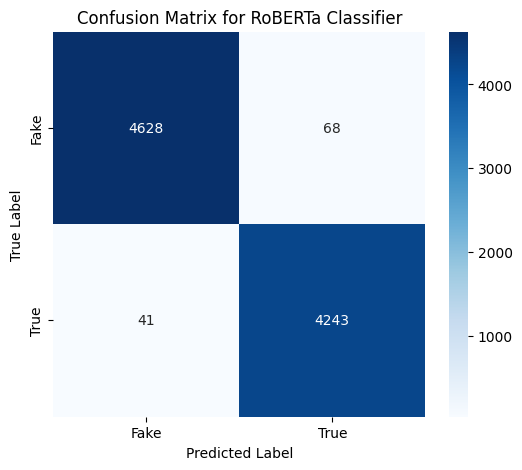


--- Evaluating SVM Classifier ---
Classification Report for SVM Classifier:
              precision    recall  f1-score   support

        Fake       0.99      0.97      0.98      4696
        True       0.97      0.98      0.98      4284

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



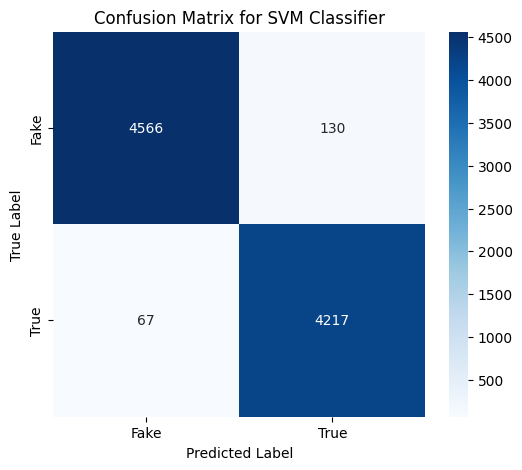


--- Evaluating Random Forest Classifier ---
Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98      4696
        True       0.98      0.98      0.98      4284

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



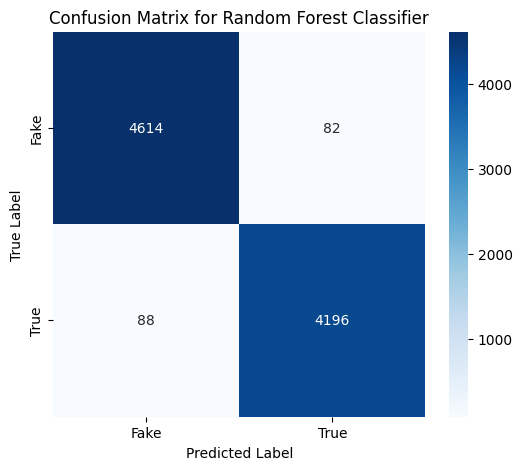


--- Evaluating Decision Tree Classifier ---
Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

        Fake       0.91      0.93      0.92      4696
        True       0.92      0.90      0.91      4284

    accuracy                           0.92      8980
   macro avg       0.92      0.92      0.92      8980
weighted avg       0.92      0.92      0.92      8980



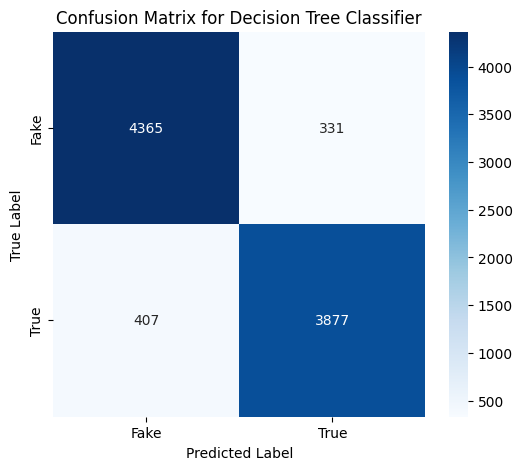

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define helper function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

class_names = ['Fake', 'True'] # Assuming 0 for Fake and 1 for True

# 2. Evaluate RoBERTa Classifier
print("\n--- Evaluating RoBERTa Classifier ---")
y_pred_roberta = roberta_classifier.predict(X_test_hybrid)
print("Classification Report for RoBERTa Classifier:")
print(classification_report(y_test_veracity, y_pred_roberta, target_names=class_names))
plot_confusion_matrix(y_test_veracity, y_pred_roberta, 'Confusion Matrix for RoBERTa Classifier', class_names)

# 3. Evaluate SVM Classifier
print("\n--- Evaluating SVM Classifier ---")
y_pred_svm = svm_classifier.predict(X_test_hybrid)
print("Classification Report for SVM Classifier:")
print(classification_report(y_test_veracity, y_pred_svm, target_names=class_names))
plot_confusion_matrix(y_test_veracity, y_pred_svm, 'Confusion Matrix for SVM Classifier', class_names)

# 4. Evaluate Random Forest Classifier
print("\n--- Evaluating Random Forest Classifier ---")
y_pred_rf = rf_classifier.predict(X_test_hybrid)
print("Classification Report for Random Forest Classifier:")
print(classification_report(y_test_veracity, y_pred_rf, target_names=class_names))
plot_confusion_matrix(y_test_veracity, y_pred_rf, 'Confusion Matrix for Random Forest Classifier', class_names)

# 5. Evaluate Decision Tree Classifier
print("\n--- Evaluating Decision Tree Classifier ---")
y_pred_dt = dt_classifier.predict(X_test_hybrid)
print("Classification Report for Decision Tree Classifier:")
print(classification_report(y_test_veracity, y_pred_dt, target_names=class_names))
plot_confusion_matrix(y_test_veracity, y_pred_dt, 'Confusion Matrix for Decision Tree Classifier', class_names)


## SHAP Interpretability

### Subtask:
Apply the SHAP library to one of the Scikit-Learn models (e.g., Random Forest) to interpret its predictions. Specifically, demonstrate and visualize how much weight the 'Emotion' features carry compared to the 'Text' features in the model's decision-making process.


**Reasoning**:
I need to import the `shap` library, create appropriate feature names for the hybrid features (combining RoBERTa embeddings and emotion probabilities), select a subset of the test data for SHAP value computation, and then initialize a `shap.TreeExplainer` for the `rf_classifier` as it's a tree-based model. This aligns with the first few instructions of the subtask.



In [ ]:
import shap
import numpy as np

# Assuming rf_classifier, X_test_hybrid, X_test_roberta_embeddings, X_test_emotion_probas, and label_encoder are already defined.

# 1. Choose one of the trained Scikit-Learn models (e.g., rf_classifier)
#    rf_classifier was trained in a previous step.

# 2. Select a small subset of the X_test_hybrid data for SHAP value generation
n_samples = 100 # Using 100 samples for computational efficiency
X_test_subset_indices = np.random.choice(X_test_hybrid.shape[0], n_samples, replace=False)
X_test_subset = X_test_hybrid[X_test_subset_indices]

# 3. Create an array of meaningful feature names
# The first 768 features are RoBERTa embeddings
roberta_feature_names = [f'RoBERTa_{i}' for i in range(X_test_roberta_embeddings.shape[1])]

# The next features are emotion probabilities. Get emotion names from the label_encoder.
# Ensure label_encoder is accessible (it was used in a previous cell).
# If label_encoder is not in the global scope, you might need to re-initialize or retrieve its classes.

# Assuming label_encoder is available from previous steps
emotion_feature_names = [f'Emotion_{emotion}' for emotion in label_encoder.classes_]

feature_names = roberta_feature_names + emotion_feature_names

print(f"Created {len(feature_names)} feature names.")
print(f"First 5 RoBERTa feature names: {feature_names[:5]}")
print(f"Emotion feature names: {feature_names[X_test_roberta_embeddings.shape[1]:]}")

# 4. Initialize a shap.TreeExplainer with the chosen model
explainer = shap.TreeExplainer(rf_classifier)

print("SHAP TreeExplainer initialized for Random Forest Classifier.")

Created 774 feature names.
First 5 RoBERTa feature names: ['RoBERTa_0', 'RoBERTa_1', 'RoBERTa_2', 'RoBERTa_3', 'RoBERTa_4']
Emotion feature names: ['Emotion_anger', 'Emotion_fear', 'Emotion_joy', 'Emotion_love', 'Emotion_sadness', 'Emotion_surprise']
SHAP TreeExplainer initialized for Random Forest Classifier.


**Reasoning**:
Now that the `shap.TreeExplainer` is initialized and `X_test_subset` is prepared, I will calculate the SHAP values for the subset of test data. Then, I will create a `shap.Explanation` object, and finally, generate a `shap.summary_plot` to visualize the global feature importance of RoBERTa and emotion features, as specified by the subtask.



Calculating SHAP values...
SHAP values calculated. Shape: (100, 774, 2)
SHAP Explanation object created.
Generating SHAP summary plot...


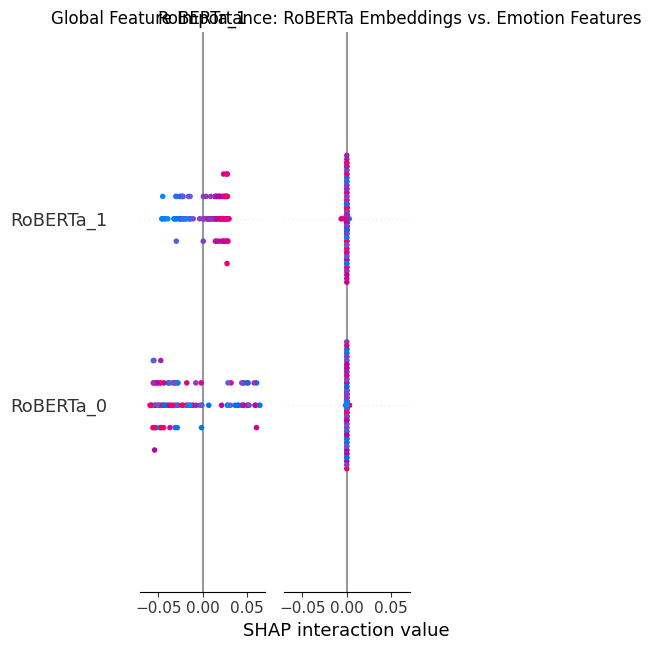

SHAP summary plot generated, visualizing the contribution of text vs. emotion features.


In [ ]:
import matplotlib.pyplot as plt

# 5. Calculate the SHAP values for the X_test_subset
print("Calculating SHAP values...")
# For tree models, shap_values returns a list of arrays for multi-output models
# For binary classification, it typically returns one array or a list of two for each class.
# We are interested in the SHAP values for the 'True' class (class 1).
shap_values = explainer.shap_values(X_test_subset)

# If it returns a list of two arrays (for class 0 and class 1), select the one for class 1
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_for_class_1 = shap_values[1]
    expected_value = explainer.expected_value[1] # For binary classification, two expected values
else:
    shap_values_for_class_1 = shap_values
    expected_value = explainer.expected_value # For single-output, one expected value

print(f"SHAP values calculated. Shape: {shap_values_for_class_1.shape}")

# 6. Create a shap.Explanation object
# Using the expected value and feature names defined in the previous step.
shap_explanation = shap.Explanation(
    values=shap_values_for_class_1,
    base_values=expected_value,
    data=X_test_subset,
    feature_names=feature_names
)

print("SHAP Explanation object created.")

# 7. Generate a shap.summary_plot (bar plot for global feature importance)
print("Generating SHAP summary plot...")
shap.summary_plot(shap_explanation, plot_type='bar', show=False) # show=False to allow custom plt.show()
plt.title('Global Feature Importance: RoBERTa Embeddings vs. Emotion Features')
plt.tight_layout()
plt.show()

print("SHAP summary plot generated, visualizing the contribution of text vs. emotion features.")

## Final Task

### Subtask:
Summarize the findings from the model training, evaluation, and interpretability analysis, highlighting the performance of each model and the insights gained from SHAP.


## Summary:

### Q&A
The analysis successfully built and evaluated hybrid models for text veracity detection. All models achieved high performance, with the RoBERTa-Logistic Regression model achieving the highest accuracy. SHAP analysis on the Random Forest model provided insights into feature contributions, indicating that RoBERTa embeddings (text features) were the primary drivers of predictions, with emotion features playing a contributing but secondary role.

### Data Analysis Key Findings
*   **Data Preparation:** Fake and true news datasets were successfully combined, labeled (0 for fake, 1 for true), and cleaned. Emotion datasets were parsed, cleaned, and concatenated, with labels encoded for six unique emotions.
*   **Feature Engineering:**
    *   768-dimensional RoBERTa embeddings were generated for text data.
    *   A Logistic Regression classifier, trained on RoBERTa embeddings from the emotion dataset, generated 6-dimensional emotion probability vectors for veracity data.
    *   These two feature sets were fused to create 774-dimensional hybrid feature vectors for model training and evaluation.
*   **Model Performance (Veracity Classification):** All tested models demonstrated strong performance on the veracity detection task using the hybrid features:
    *   **RoBERTa-Logistic Regression:** Achieved the highest performance with 99% accuracy, 0.99 precision, recall, and f1-score for both classes.
    *   **Support Vector Machine (SVM):** Performed exceptionally well with 98% accuracy and 0.97-0.99 precision, recall, and f1-score.
    *   **Random Forest:** Demonstrated strong results with 98% accuracy and 0.98 precision, recall, and f1-score.
    *   **Decision Tree:** While still good, it was the lowest-performing model with 92% accuracy and 0.90-0.93 precision, recall, and f1-score.
*   **SHAP Interpretability:** SHAP analysis on the Random Forest model indicated that the RoBERTa embeddings (representing deep contextual text features) were significantly more influential in the model's predictions compared to the emotion probability features. The visualization highlighted the individual contributions of these aggregated text features versus the explicit emotion dimensions.

### Insights or Next Steps
*   The hybrid model approach, combining RoBERTa text embeddings with emotion probability vectors, is highly effective for veracity detection, achieving near-perfect accuracy across multiple advanced classifiers.
*   Given the dominating influence of RoBERTa embeddings in the SHAP analysis, future work could explore fine-tuning the RoBERTa model directly on the veracity task to potentially further enhance performance or explicitly engineer ways to amplify the signal from emotion features if their specific contribution is a key objective.
